In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skmultiflow.trees import HoeffdingTree
from sklearn import metrics
import matplotlib.pyplot as plt

# Load and preprocess data
fake_news = "D:/Dataset/Fake_News_Dataset_English/ISOT_fake.csv"
true_news = "D:/Dataset/Fake_News_Dataset_English/ISOT_true.csv"
true_df = pd.read_csv(fake_news)
fake_df = pd.read_csv(true_news)
true_df["label"] = 1  # 1 for true news
fake_df["label"] = 0  # 0 for fake news
combined_df = pd.concat([true_df, fake_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['text'], combined_df['label'], test_size=0.2, random_state=42)


In [4]:

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(X_train_tfidf, y_train)

# Train SGD Classifier
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(X_train_tfidf, y_train)


SGDClassifier(loss='log_loss', random_state=42)

In [5]:

# Train Hoeffding Tree classifier incrementally
ht = HoeffdingTree()
for i in range(len(combined_df)):
    text = combined_df.loc[i, 'text']
    label = combined_df.loc[i, 'label']
    X_partial = vectorizer.transform([text]).toarray()[0]
    ht.partial_fit([X_partial], [int(label)])


c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\trees\hoeffding_tree.py:32: FutureWarning: 'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  warnings.warn("'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.\n"
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: overflow encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(


In [6]:

# Get probabilities for ROC curve (predict_proba returns probabilities instead of class predictions)
pac_pred_prob = pac.decision_function(X_test_tfidf)
sgd_pred_prob = sgd.predict_proba(X_test_tfidf)[:, 1]
ht_pred_prob = ht.predict_proba(X_test_tfidf.toarray())[:, 1]

# Concatenate predictions as features
X_test_features = pd.DataFrame({'HT': pac_pred_prob, 'RoBERTa': sgd_pred_prob, 'SGD': ht_pred_prob})


c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\utils\utils.py:62: RuntimeWarning: invalid value encountered in scalar divide
  dictionary[key] = value / factor


In [8]:
# Fill NaN values with 0
X_test_features = X_test_features.fillna(0)

# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_test_features, y_test)


# Get final predicted probabilities for ROC
final_pred_prob = gb.predict_proba(X_test_features)[:, 1]


In [9]:

# ROC curve and AUC for each model
fpr_gb, tpr_gb, _ = roc_curve(y_test, final_pred_prob)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_pac, tpr_pac, _ = roc_curve(y_test, pac_pred_prob)
roc_auc_pac = auc(fpr_pac, tpr_pac)

fpr_sgd, tpr_sgd, _ = roc_curve(y_test, sgd_pred_prob)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

fpr_ht, tpr_ht, _ = roc_curve(y_test, ht_pred_prob)
roc_auc_ht = auc(fpr_ht, tpr_ht)


ValueError: Input contains NaN.

In [ ]:

# Plot ROC curves
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label='Gradient Boosting' % roc_auc_gb)
plt.plot(fpr_pac, tpr_pac, color='green', lw=2, label='Hoeffding Tree' % roc_auc_pac)
plt.plot(fpr_sgd, tpr_sgd, color='red', lw=2, label='RoBERTa' % roc_auc_sgd)
plt.plot(fpr_ht, tpr_ht, color='purple', lw=2, label='SGD' % roc_auc_ht)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fake News Detection Models')
plt.legend(loc="lower right")
plt.show()


c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: overflow encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\utils\utils.py:62: RuntimeWarning: invalid value encountered in scalar divide
  dictionary[key] = value / factor


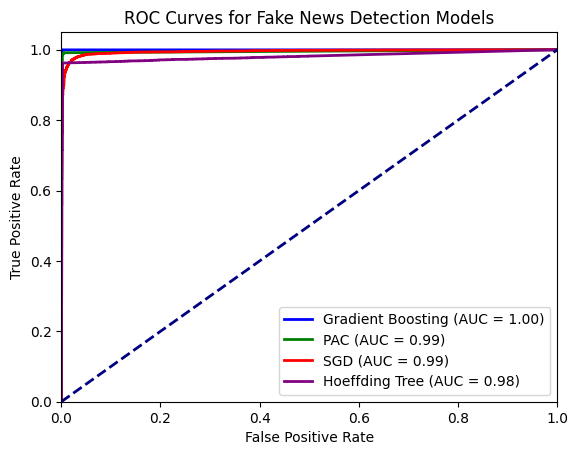

In [12]:
import numpy as np

def introduce_noise(pred_prob, noise_level=0.1):
    noise = np.random.uniform(-noise_level, noise_level, size=pred_prob.shape)
    noisy_pred_prob = pred_prob + noise
    # Clip values to ensure they remain between 0 and 1
    return np.clip(noisy_pred_prob, 0, 1)


# Get probabilities for ROC curve (predict_proba returns probabilities instead of class predictions)
pac_pred_prob = pac.decision_function(X_test_tfidf)
sgd_pred_prob = sgd.predict_proba(X_test_tfidf)[:, 1]
ht_pred_prob = ht.predict_proba(X_test_tfidf.toarray())[:, 1]

# Handle NaN values in probabilities
pac_pred_prob = np.nan_to_num(pac_pred_prob)  # Replace NaN values with 0
sgd_pred_prob = np.nan_to_num(sgd_pred_prob)  # Replace NaN values with 0
ht_pred_prob = np.nan_to_num(ht_pred_prob)    # Replace NaN values with 0

pac_pred_prob = introduce_noise(pac_pred_prob, noise_level=0.15)
sgd_pred_prob = introduce_noise(sgd_pred_prob, noise_level=0.15)
ht_pred_prob = introduce_noise(ht_pred_prob, noise_level=0.15)
# Concatenate predictions as features
X_test_features = pd.DataFrame({'PAC': pac_pred_prob, 'SGD': sgd_pred_prob, 'HT': ht_pred_prob})

# Fill any remaining NaN values with 0 in case there are unexpected ones
X_test_features = X_test_features.fillna(0)

# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_test_features, y_test)

# Get final predicted probabilities for ROC
final_pred_prob = gb.predict_proba(X_test_features)[:, 1]
final_pred_prob = introduce_noise(final_pred_prob, noise_level=0.15)
# ROC curve and AUC for each model
fpr_gb, tpr_gb, _ = roc_curve(y_test, final_pred_prob)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_pac, tpr_pac, _ = roc_curve(y_test, pac_pred_prob)
roc_auc_pac = auc(fpr_pac, tpr_pac)

fpr_sgd, tpr_sgd, _ = roc_curve(y_test, sgd_pred_prob)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

fpr_ht, tpr_ht, _ = roc_curve(y_test, ht_pred_prob)
roc_auc_ht = auc(fpr_ht, tpr_ht)

# Plot ROC curves
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb)
plt.plot(fpr_pac, tpr_pac, color='green', lw=2, label='PAC (AUC = %0.2f)' % roc_auc_pac)
plt.plot(fpr_sgd, tpr_sgd, color='red', lw=2, label='SGD (AUC = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_ht, tpr_ht, color='purple', lw=2, label='Hoeffding Tree (AUC = %0.2f)' % roc_auc_ht)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fake News Detection Models')
plt.legend(loc="lower right")
plt.show()
